# Modelo de Tópicos - Latent Dirichlet Allocation

## Motivación

Los __modelos de tópicos__ permiten descubrir, a partir de los propios textos, el conjunto de tópicos o temas que estos abordan. Se trata de un análisis automatizado, que sería muy difícil de llevar a cabo manualmente por personas, debido a la cantidad y tamaño de los textos.

- Revisar el artículo "Probabilistic Topic Models" : https://drive.google.com/open?id=1rSQPJvRVj0V_IChzspQMRPNwlDTkHYHp

Uno de los algoritmos más comunes para aprender modelos de tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_. LDA modela os textos como provenientes de un modelo generativo, con una estructura oculta de tópicos y distribución de palabras en cada tópico, cuyas distribuciones a priori son Dirichlet.

- Revisar el artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view



## ¿Qué hace Latent Dirichlet Allocation?

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## Tutorial práctico

En este tutorial, tomaremos un dataset de posts en un foro en inglés y utilizaremos a LDA para descubrir cuáles son los tópicos conversados.

Utilizaremos la implementación de LDA de la libreria Gensim.

### 1.  Instalación de librerias y depedencias

Utilizaremos en particular:
- la libreria NLTK (Natural Language ToolKit) para tener una lista de "stopwords" del inglés
- el modelo inglés de Spacy para preprocesar los textos y lematizar las palabras
- la librería pyLDAvis que ofrece algunas herramientas de visualización de modelos de tópicos

In [ ]:
!pip install nltk

In [4]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mvernier/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Run in terminal or command prompt
!python -m spacy download en_core_web_sm

In [ ]:
!pip install pyLDAvis

In [81]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

### 2. Dataset y preprocessing

El dataset que utilizamos contiene aproximadamente 11.000 posts en el foro newsgroup donde las personas pueden hablar de distintos temas. 

In [82]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [84]:
df["content"][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

- Utilizamos expresiones regulares (libreria "re") para suprimir los emails, espacios blancos y caracteres que podrian generan ruido en el análisis.

In [86]:
# Convert to list
data = df.content.values.tolist()
data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [87]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[0]

'From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- '

- Gensim tiene una función "simple_preprocess" que tokeniza los textos, suprima las puntuaciones y transforma un texto en una lista de tokens

In [89]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

In [91]:
print(data_words[0])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


- Para extraer los tópicos de un conjunto de documentos, puede ser muy relevante añadir "conceptos" (palabras de más de 1 token) a nuestro vocabulario. Por lo tanto guardaremos tambien los "bigrams" y "trigrams" más frecuentes.

In [92]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [96]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[16]]])

['from', 'allen', 'subject', 're', 'tiff_philosophical_significance', 'of', 'organization', 'purdue_university', 'lines', 'in', 'article', 'martin_preston', 'writes', 'why', 'not', 'use', 'the', 'pd', 'library', 'for', 'reading', 'writing', 'tiff', 'files', 'it', 'took', 'me', 'good', 'minutes', 'to', 'start', 'using', 'them', 'in', 'your', 'own', 'app', 'certainly', 'do', 'use', 'it', 'whenever', 'have', 'to', 'do', 'tiff', 'and', 'it', 'usually', 'works', 'very', 'well', 'thats', 'not', 'my', 'point', 'im', 'philosophically', 'opposed', 'to', 'it', 'because', 'of', 'its', 'complexity', 'this', 'complexity', 'has', 'led', 'to', 'some', 'programs', 'poor', 'tiff', 'writers', 'making', 'some', 'very', 'bizarre', 'files', 'other', 'programs', 'inability', 'to', 'load', 'tiff', 'images', 'though', 'theyll', 'save', 'them', 'of', 'course', 'and', 'general', 'inability', 'to', 'interchange', 'images', 'between', 'different', 'environments', 'despite', 'the', 'fact', 'they', 'all', 'think', 

In [97]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

- Se aplican las funciones para suprimir stopwords, añadir bigrams y lematizar las palabras con los modelos de spacy

In [98]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd', 'organization', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


In [100]:
print(data_lemmatized[1])

['si', 'clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'si', 'clock', 'report', 'keyword', 'acceleration', 'clock', 'upgrade', 'article', 'shelley', 'qvfo', 'innc', 'organization', 'university', 'washington', 'line', 'nntp_poste', 'host', 'fair', 'number', 'brave', 'soul', 'upgrade', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'cpu', 'rate', 'speed', 'add', 'card', 'adapter', 'heat_sink', 'hour', 'usage', 'day', 'floppy_disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'day', 'add', 'network', 'knowledge', 'base', 'do', 'clock', 'upgrade', 'have', 'answer', 'poll', 'thank']


### 3. Preparar los datos de input de LDA

los datos de input principales de LDA son: un diccionario (id2word) y nuestro dataset preprocesado (data_lemmatized).

In [103]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario

In [107]:
id2word[0]

'addition'

In [108]:
# Create Corpus
texts = data_lemmatized

- Se crea una representación "Bag of words" del dataset como input de LDA.

Nota Bene: existen implementaciones de LDA que reciben como input representaciones con "Word Embedding". Ver por ejemplo: https://towardsdatascience.com/combing-lda-and-word-embeddings-for-topic-modeling-fe4a1315a5b4 

In [109]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]]


In [112]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('saw', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

### 4. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 20 tópicos. 

In [113]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### 5. Visualizar los tópicos encontrados

In [121]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics(num_words=25))


[(0,
  '0.587*"ax" + 0.097*"_" + 0.047*"max" + 0.020*"screen" + 0.013*"mouse" + '
  '0.008*"mr" + 0.007*"modem" + 0.006*"el" + 0.005*"cds" + 0.005*"honda" + '
  '0.005*"ex" + 0.004*"default" + 0.004*"ron" + 0.004*"charle" + 0.004*"sam" + '
  '0.003*"film" + 0.003*"m" + 0.003*"stable" + 0.003*"fancy" + 0.003*"plot" + '
  '0.002*"buffer" + 0.002*"ins_cwru" + 0.002*"mailing_list" + 0.002*"bolt" + '
  '0.002*"catalog"'),
 (1,
  '0.079*"key" + 0.041*"chip" + 0.022*"encryption" + 0.021*"server" + '
  '0.019*"technology" + 0.019*"security" + 0.018*"clipper" + 0.016*"algorithm" '
  '+ 0.016*"controller" + 0.015*"system" + 0.014*"bit" + 0.013*"secure" + '
  '0.012*"tap" + 0.012*"clipper_chip" + 0.012*"public" + 0.012*"secret" + '
  '0.012*"agency" + 0.012*"communication" + 0.012*"trust" + 0.011*"block" + '
  '0.011*"government" + 0.011*"information" + 0.011*"datum" + 0.011*"message" '
  '+ 0.010*"use"'),
 (2,
  '0.033*"self" + 0.028*"normal" + 0.024*"son" + 0.023*"proof" + '
  '0.023*"father" +

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.380210 -0.059185       1        1  37.336160
14    -0.279709  0.252937       2        1  12.675935
9     -0.336351 -0.091878       3        1  12.189029
3     -0.293166 -0.108159       4        1  10.961358
0      0.013248 -0.085931       5        1   5.634582
8     -0.118498 -0.167956       6        1   4.905026
7     -0.018359  0.011658       7        1   2.559531
1     -0.039473  0.259524       8        1   2.434722
13     0.024025  0.065406       9        1   2.319596
16     0.023623  0.089729      10        1   1.609666
5      0.077405 -0.004269      11        1   1.512056
6      0.084438  0.039256      12        1   1.393184
2      0.121325 -0.014353      13        1   1.071527
12     0.102506 -0.069289      14        1   0.968244
18     0.153380 -0.035470      15        1   0.729643
17     0.142396 -0.034967      16        1   0.694763
19     0.148597  0.026361      17        1   0.491452
10     0.178794 -0.027761      18        1   0.341416
11     0.195759 -0.023402      19        1   0.120482
4      0.200270 -0.022252      20        1   0.051627, topic_info=               Term          Freq         Total Category  logprob  loglift
5421             ax  50761.000000  50761.000000  Default  30.0000  30.0000
1086              _   8392.000000   8392.000000  Default  29.0000  29.0000
26     organization  17488.000000  17488.000000  Default  28.0000  28.0000
18             line  19144.000000  19144.000000  Default  27.0000  27.0000
421           drive   2474.000000   2474.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
5208       familiar      0.010148      1.266632  Topic20 -11.2648   2.7421
11901             p      0.010148      1.266626  Topic20 -11.2648   2.7421
4497           loss      0.010148      1.266665  Topic20 -11.2648   2.7420
9087           phil      0.010148      1.266649  Topic20 -11.2648   2.7421
4711        capable      0.010148      1.266667  Topic20 -11.2648   2.7420

[856 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1086      5  0.999924            _
406      19  0.904964       absurd
1588      3  0.998559       accept
1308     17  0.974785  acquisition
2073      3  0.017428       action
...     ...       ...          ...
45        1  0.373413         year
45        4  0.185013         year
45        6  0.429689         year
45        7  0.011669         year
2607     18  0.994202         zone

[1036 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 15, 10, 4, 1, 9, 8, 2, 14, 17, 6, 7, 3, 13, 19, 18, 20, 11, 12, 5])

### 6. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [122]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.272997192451127

Coherence Score:  0.5060396843924693


### 7. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

Buscar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad).

In [123]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=5)

2
7
12
17
22
27


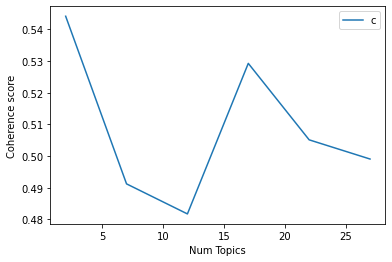

In [124]:
# Show graph
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5441
Num Topics = 7  has Coherence Value of 0.4912
Num Topics = 12  has Coherence Value of 0.4817
Num Topics = 17  has Coherence Value of 0.5293
Num Topics = 22  has Coherence Value of 0.5051
Num Topics = 27  has Coherence Value of 0.4991


In [125]:
# Select the model and print the topics
optimal_model = model_list[3]
#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.606*"ax" + 0.100*"_" + 0.049*"max" + 0.007*"mr" + 0.006*"rob" + '
  '0.006*"mu" + 0.005*"collin" + 0.005*"honda" + 0.005*"daughter" + '
  '0.004*"ron"'),
 (1,
  '0.079*"key" + 0.034*"public" + 0.024*"government" + 0.023*"security" + '
  '0.022*"encryption" + 0.018*"chip" + 0.018*"private" + 0.017*"clipper" + '
  '0.016*"self" + 0.015*"system"'),
 (2,
  '0.097*"space" + 0.030*"earth" + 0.025*"launch" + 0.023*"moon" + '
  '0.023*"nasa" + 0.022*"mission" + 0.022*"orbit" + 0.021*"rsa" + '
  '0.018*"satellite" + 0.017*"iran"'),
 (3,
  '0.025*"people" + 0.024*"god" + 0.018*"say" + 0.017*"evidence" + '
  '0.017*"believe" + 0.016*"reason" + 0.013*"christian" + 0.012*"claim" + '
  '0.011*"law" + 0.010*"sense"'),
 (4,
  '0.079*"monitor" + 0.067*"character" + 0.056*"normal" + 0.037*"font" + '
  '0.034*"excuse" + 0.024*"left" + 0.018*"trivial" + 0.011*"click" + '
  '0.010*"upper" + 0.010*"ms_window"'),
 (5,
  '0.054*"suggest" + 0.046*"wire" + 0.029*"clipper_chip" + 0.026*"weight" + '
  '

In [126]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.353041  0.134332       1        1  29.551302
8     -0.278845 -0.132883       2        1  18.225983
9     -0.287917  0.036576       3        1  14.591114
3     -0.283692  0.216163       4        1  11.447279
14    -0.171588 -0.308452       5        1   7.470126
0      0.039499 -0.020851       6        1   5.460679
6     -0.070908  0.057382       7        1   3.717747
13    -0.001810  0.030467       8        1   2.874437
1     -0.006056 -0.183533       9        1   2.410068
2      0.113414 -0.035793      10        1   1.095466
12     0.148700  0.060302      11        1   0.860058
5      0.165005  0.024241      12        1   0.732984
16     0.168508  0.020582      13        1   0.619807
7      0.201030  0.025635      14        1   0.325531
4      0.200235  0.025650      15        1   0.292575
10     0.203667  0.025542      16        1   0.241791
11     0.213799  0.024640      17        1   0.083053, topic_info=               Term          Freq         Total Category  logprob  loglift
5421             ax  50746.000000  50746.000000  Default   30.000  30.0000
18             line  19019.000000  19019.000000  Default   29.000  29.0000
26     organization  17457.000000  17457.000000  Default   28.000  28.0000
1086              _   8389.000000   8389.000000  Default   27.000  27.0000
59               do  14713.000000  14713.000000  Default   26.000  26.0000
...             ...           ...           ...      ...      ...      ...
10106            ne      0.016047      1.239094  Topic17  -11.282   2.7469
5595             mc      0.016048      1.240202  Topic17  -11.282   2.7460
5720             vl      0.016047      1.238894  Topic17  -11.282   2.7470
5605             mk      0.016047      1.239188  Topic17  -11.282   2.7468
70058           tdo      0.016047      1.238878  Topic17  -11.282   2.7470

[776 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1086      6  0.999887          _
1588      3  0.892165     accept
1588      7  0.107227     accept
95        2  0.020078     access
95        5  0.685007     access
...     ...       ...        ...
45        3  0.141138       year
45        7  0.034619       year
45        8  0.201246       year
2171      6  0.987067  youve_got
2607     14  0.993242       zone

[966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 9, 10, 4, 15, 1, 7, 14, 2, 3, 13, 6, 17, 8, 5, 11, 12])

### 8. ¿Cuál es el tópico principal de cada documento?

In [141]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.5832,"do, get, go, know, think, well, write, make, say, good","[where, s, thing, car, nntp_poste, host, rac_wam, umd, organization, university, park, line, wonder, enlighten, car, saw, day, door, sport, car, look, late, early, call, bricklin, door, really, small, addition, separate, rest, body, know, tellme, model, name, engine, spec, year, production, car, make, history, info, funky, look, car, mail, thank, bring, neighborhood, lerxst]"
1,1,14.0,0.2785,"drive, window, file, program, system, card, use, run, problem, driver","[si, clock, poll, final, call, summary, final, call, si, clock, report, keyword, acceleration, clock, upgrade, article, shelley, qvfo, innc, organization, university, washington, line, nntp_poste, host, fair, number, brave, soul, upgrade, clock, oscillator, share, experience, poll, send, brief, message, detail, experience, procedure, top, speed, attain, cpu, rate, speed, add, card, adapter, heat_sink, hour, usage, day, floppy_disk, functionality, floppy, especially, request, summarize, day, add, network, knowledge, base, do, clock, upgrade, have, answer, poll, thank]"
2,2,15.0,0.5303,"do, get, go, know, think, well, write, make, say, good","[thoma, willi, pb, question, organization, purdue_university, engineering, computer, network, line, folk, mac, finally, give, ghost, weekend, start, life, way, back, sooo, m, market, new, machine, bit, soon, intend, m, look, pick, powerbook, maybe, bunch, question, hopefully, answer, know, dirt, next, round, powerbook, introduction, expect, d, hear, suppose, make, appearence, summer, have, hear, anymore, do, access, macleak, wonder, info, hear, rumor, price, drop, powerbook, line, one, duo, go, recently, s, impression, display, probably, swing, get, disk, rather, do, really, feel, much, well, display, yea, look, great, store, really, good, solicit, opinion, people, day, day, worth, take, disk, size, money, hit, get, ...]"
3,3,8.0,0.4440,"line, organization, nntp_poste, write, university, host, article, reply, thank, mail","[joe, green, weitek, organization, harris, computer, system, division, line, nntp_poste, host, amber, ssd_csd, version_pl, write, write, article, know, weitek, graphic, chip, far, low_level, stuff, go, look, pretty, nice, get, quadrilateral, fill, command, require, point, weitek, address, phone, number, i, d, get, information, chip, joe, green, harris, corporation, computer, system, division, thing, really, scare, person, sense, humor, jonathan, winter]"
4,4,8.0,0.4988,"line, organization, nntp_poste, write, university, host, article, reply, thank, mail","[jonathan, mcdowell, shuttle_launch, question, organization, smithsonian_astrophysical, observatory, cambridge, usa, distribution, sci, line, article, tom, baker, article, pack, rat, write, clear, caution, warn, memory, verify, unexpected, error, wonder, expect, error, sorry, really, dumb, question, parity_error, memory, previously, know, condition, waivere, error, already, know, d, curious, real, meaning, tom, understanding, expect, error, basically, know, bug, warn, system, software, thing, check, do, right, value, yet, be, set, launch, suchlike, rather, fix, code, possibly, introduce, new, bug, tell, crew, see, warn, liftoff, ignore, jonathan]"
5,5,3.0,0.3977,"people, god, say, evidence, believe, reason, christian, claim, law, sense","[foxvog_dougla, reword, second_amendment, idea, organization, vtt, line, article, tavare, write, article, write, article, tavare, write, article, john, write, massive, destructive, power, many, modern, weapon, make, cost, accidental, crimial, usage, weapon, great, weapon, mass_destruction, need, control, government, individual, access, result, needless, death, million, make, right, people, keep, bear, many, modern, weapon, thank, state, re, come, needless, say, disagree, count, believe, individual, right, weapon, mass_destruction, find, hard, believe, support, neighbor, right, keep, nuclear_weapo

In [142]:
pd.options.display.max_colwidth = 1000

print(df_dominant_topic[:10]["Text"])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [where, s, thing, car, nntp_poste, host, rac_wam, umd, organization, university, park, line, wonder, enlighten, car, saw, day, door, sport, car, look, late, early, call, bricklin, door, really, small, addition, separate, rest, body, know, tellme, model, name, engine, spec, year, production, car, make, history, info, funky, look, car, mail, thank, bring, neighborhood, lerxst]
1                                                                                                                                                       